Video was given from https://motchallenge.net/vis/MOT16-04

In [30]:
# !pip install distinctipy==1.2.2 filterpy==1.4.5 lap==0.4.0 -q

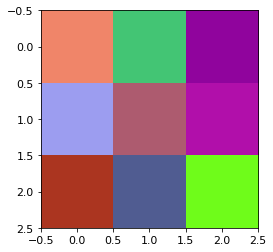

In [182]:
import torch
import cv2
import numpy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sort import Sort
import distinctipy

sample_img = np.random.rand(3,3,3)
plt.imshow(sample_img)

In [183]:
device = 'cuda:0'

In [184]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True).to(device)
model.float()
model.eval()
1

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-22 Python-3.8.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


1

In [185]:
from pathlib import Path

data_dir = Path('data')

reference_vid = data_dir / 'ref_vid.mp4'

save_to = data_dir / 'hungurian_baseline_results' / reference_vid.stem
save_to.mkdir(exist_ok=True, parents=True)

In [186]:
mot_tracker = Sort()

In [187]:
! rm -rf /app/notebooks/object_tracking/data/hungurian_baseline_results/ref_vid/*

In [188]:
import torch
from torchvision.ops import box_iou
from scipy.optimize import linear_sum_assignment

def hungarian_match(bboxs1, bboxs2, min_iou = 0.3):
    """
    bboxs1: m x 4
    bboxs2: n x 4
    returns: m x 1
    """
    ious = box_iou(bboxs1,bboxs2).cpu().numpy()
    row_ind, col_ind = linear_sum_assignment(-ious)
    
    new_row_ind, new_col_ind = [], []
    
    for m in zip(row_ind, col_ind):
        if(ious[m[0], m[1]]>=min_iou):
            new_row_ind.append(m[0])
            new_col_ind.append(m[1])
    
    return np.array(new_row_ind), np.array(new_col_ind)

def color_t(idx):
    state = np.random.get_state()
    numpy.random.seed(seed=idx)
    val = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    np.random.set_state(state)
    return val

def update_trackers(trackers, detections, max_idx):
    """
    trackers - objects that we currently tracking
    detections - not yet classified bboxes that detected on new frame
    
    From detections we want to understand few things:
    1. Who is new to trackers?
    2. Who is lost from trackers?
    """
    if len(trackers) == 0: 
        trks_inds = torch.arange(len(detections)).unsqueeze(-1).to(device)
        return torch.cat([detections, trks_inds], dim=-1), len(detections)+1
    
    max_id = trackers[..., 4].max().item()
    
    max_id = max(max_id, max_idx)
    
    row_ind, col_ind = hungarian_match(trackers[..., :4], detections)
    
    new_detection_ind = set(range(len(detections))) - set(col_ind) 
    
    tracked_ind = set(row_ind)
    
    trackers[list(row_ind), :4] = detections[list(col_ind)]
    trackers = trackers[list(tracked_ind)]
    
    new_detected = detections[list(new_detection_ind)]
    new_trackers_inds = torch.arange(max_id+1, max_id+len(new_detected)+1).unsqueeze(-1).to(device)
    new_trackers = torch.cat([new_detected,new_trackers_inds], dim=-1)
    
    trackers = torch.cat([trackers, new_trackers], dim=0)
    
    return trackers, max_id+len(new_detected)+1

In [220]:
import math
from filterpy.kalman import KalmanFilter
from numpy.random import randn

def convert_bbox_to_z(bbox):
    x1, y1, x2, y2 = bbox
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    scale = (x2 - x1) * (y2 - y1)
    aspect_ratio = (x2 - x1) / (y2 - y1)

    return np.array([center_x, center_y, scale, aspect_ratio]).reshape((4, 1))

def convert_x_to_bbox(z):
    center_x, center_y, scale, aspect_ratio = z
    width = math.sqrt(scale * aspect_ratio)
    height = math.sqrt(scale / aspect_ratio)
    x1 = center_x - width / 2
    y1 = center_y - height / 2
    x2 = center_x + width / 2
    y2 = center_y + height / 2

    return np.array([x1, y1, x2, y2]).reshape((1,4))

class KalmanBoxTracker(object):
    def __init__(self,bbox):
        self.idx = bbox[4]
        bbox = bbox[:4]
        
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4) 
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
        self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox)

    def update(self,bbox):
        self.kf.update(convert_bbox_to_z(bbox[:4]))

    def predict(self):
        self.kf.predict()
        return convert_x_to_bbox(self.kf.x[:4])

    def get_state(self):
        return convert_x_to_bbox(self.kf.x[:4])

In [221]:
class CustSORT:
    def __init__(self):
        self.trackers = []
        self.max_trackers_id = 0
        
    def update(self, detections):
        if self.trackers == []:
            track_bbs_ids, self.max_trackers_id = update_trackers([], detections, self.max_trackers_id)
            track_bbs_ids = track_bbs_ids.cpu().numpy()
            for matched_tracker in track_bbs_ids:
                self.trackers.append(KalmanBoxTracker(matched_tracker))
            return track_bbs_ids
        
        
        bbs_trackers = []
        for i in self.trackers:
            bbox_coords = i.predict()[0]
            bbox_idx = np.array([i.idx])
            bbox_arr = np.concatenate([bbox_coords, bbox_idx])
            bbs_trackers.append(bbox_arr)
        bbs_trackers = torch.tensor(bbs_trackers).to(device).to(torch.float32)
        
        track_bbs_ids, max_trackers_id = update_trackers(bbs_trackers, detections, self.max_trackers_id)
        track_bbs_ids = track_bbs_ids.cpu().numpy()
        
        new_trackers = []
        for tracker in self.trackers:
            for matched_tracker in track_bbs_ids:
                if matched_tracker[4] == tracker.idx:
                    tracker.update(matched_tracker[:4])
                    new_trackers.append(tracker)
        
        # print("(track_bbs_ids[:, 4] > self.max_trackers_id).sum(): ", (track_bbs_ids[:, 4] > self.max_trackers_id).sum())
        # print("track_bbs_ids[:, 4].max(): ", track_bbs_ids[:, 4].max())
        counter = 0
        for matched_tracker in track_bbs_ids:
            if matched_tracker[4] > self.max_trackers_id:
                counter += 1
                # print(matched_tracker[4], self.max_trackers_id)
                new_trackers.append(KalmanBoxTracker(matched_tracker))
        
        self.max_trackers_id = max_trackers_id
                
        # print("self.max_trackers_id: ", self.max_trackers_id)
        # print("counter: ", counter)
        
        self.trackers = new_trackers
        
        result_bboxes = []
        for i in self.trackers:
            bbox_coords = i.get_state()[0]
            bbox_idx = np.array([i.idx])
            bbox_arr = np.concatenate([bbox_coords, bbox_idx])
            result_bboxes.append(bbox_arr)
        
        return np.array(result_bboxes)

In [222]:
file = str(reference_vid)
verbose = True

capture = cv2.VideoCapture(file)
fps = capture.get(cv2.CAP_PROP_FPS)
n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

bbs_ids_frame_count = {}

frames = []

sort = CustSORT()

pb = np.arange(n_frames)
if verbose:
    pb = tqdm(pb)
    
def generate_noise(detections):
    noise = (torch.randn(detections.shape) * 50).to(device)
    noise[noise < 0] *= -1.
    return noise

for i in pb:
    success, image_cv = capture.read()
    # if i > 100: break # TODO: remove this line
    
    if not success:
        break

    preds = model(image_cv)
    detections = preds.pred[0][..., :4]
    detections = detections# + generate_noise(detections)
    track_bbs_ids = sort.update(detections)
    
    for j in range(len(track_bbs_ids)):
        coords = track_bbs_ids[j]
        x1, y1, x2, y2 = int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3])
        
        name_idx = int(coords[4])
        
        if name_idx in bbs_ids_frame_count.keys():
            bbs_ids_frame_count[name_idx] += 1
        else:
            bbs_ids_frame_count[name_idx] = 1
            
        sec_per_id = bbs_ids_frame_count[name_idx] / fps
            
        name = f"ID:{name_idx}|T:{sec_per_id:.2f}s"
        color = color_t(name_idx)
        
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image_cv, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        cv2.imwrite(str(save_to / f"{int(i)}.png"), image_cv)

 10%|████████████                                                                                                                 | 101/1050 [01:23<13:03,  1.21it/s]


# Kalman filter on one bbox

In [74]:
file = str(reference_vid)
verbose = True

capture = cv2.VideoCapture(file)
fps = capture.get(cv2.CAP_PROP_FPS)
n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

bbs_ids_frame_count = {}

frames = []

track_bbs_ids = []
max_trackers_id = 0

pb = np.arange(n_frames)
if verbose:
    pb = tqdm(pb)
    
kf = None

for i in pb:
    success, image_cv = capture.read()
    if i > 395: break # TODO: remove this line
    
    if not success:
        break

    preds = model(image_cv)
    detections = preds.pred[0][..., :4]
    track_bbs_ids, max_trackers_id = update_trackers(track_bbs_ids, detections, max_trackers_id)
    
    raw_coords = track_bbs_ids[track_bbs_ids[:, 4] == 4.][0].cpu().numpy()
    
    coords = track_bbs_ids[track_bbs_ids[:, 4] == 4.][0].cpu().numpy()
    
    name_idx = int(coords[4])
    
    if kf == None:
        kf = KalmanBoxTracker(coords)
    kf.predict()[0]
    
    kf.update(coords)
    
    coords = kf.get_state()[0]
    
    x1, y1, x2, y2 = int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3])

    if name_idx in bbs_ids_frame_count.keys():
        bbs_ids_frame_count[name_idx] += 1
    else:
        bbs_ids_frame_count[name_idx] = 1

    sec_per_id = bbs_ids_frame_count[name_idx] / fps

    name = f"ID:{name_idx}|T:{sec_per_id:.2f}s"
    color = color_t(name_idx)
    color_raw = color_t(name_idx+1)

    cv2.rectangle(image_cv, (int(raw_coords[0]), int(raw_coords[1])), (int(raw_coords[2]), int(raw_coords[3])), color_raw, 2)
    cv2.putText(image_cv, name, (int(raw_coords[0]), int(raw_coords[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color_raw, 2)
    
    cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image_cv, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    cv2.imwrite(str(save_to / f"{int(i)}.png"), image_cv)

 38%|███████████████████████████████████████████████▏                                                                             | 396/1050 [00:30<00:50, 13.08it/s]


In [69]:
raw_coords[0]

521.86285

In [63]:
coords

array([     521.86,      64.777,      555.21,      156.76,           4], dtype=float32)

In [32]:
coords

tensor([521.86285,  64.77745, 555.20526, 156.76003,   4.00000], device='cuda:0')

# Save video

In [44]:
# !pip install moviepy --upgrade
# !pip install ffmpeg --upgrade

In [223]:
import cv2
import os

image_folder = str(save_to)
video_name = 'video_hungarian.mp4'
fps = 30

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
sorted_img_ids = sorted([int(i.split('.')[0]) for i in images])
images = [f"{i}.png" for i in sorted_img_ids]

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

for image in tqdm(images):
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 58.34it/s]
